In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np


# Load the prepared Dataset and verify that the price column is present

In [ ]:
df = pd.read_csv("dataset.csv", parse_dates=['time'])
df.set_index('time', inplace=True)


print(df.columns[df.columns.str.contains("price", case=False)])

Index(['price day ahead', 'price actual'], dtype='object')


# Add lag features that will be important to test the models

In [5]:
def add_lag_and_time_features(df):
    df = df.copy()
    df['lag_1h'] = df['price actual'].shift(1)
    df['lag_24h'] = df['price actual'].shift(24)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df.dropna()

df_prepared = add_lag_and_time_features(df)


# Create the windows that will be used during this stage

In [ ]:
def create_custom_sliding_windows(df):
    """
    Create windows with:
    - Window 1: train 2015, test 2016
    - Window 2: train 2015-2016, test 2017
    - Window 3: train 2015–2017, test 2018
    """
    df = df.copy()
    df = df.sort_index()

    splits = []

    configs = [
        ('2015-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),
        ('2015-01-01', '2016-12-31', '2017-01-01', '2017-12-31'),
        ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31')
    ]

    for train_start, train_end, test_start, test_end in configs:
        df_train = df.loc[train_start:train_end]
        df_test = df.loc[test_start:test_end]
        splits.append((df_train, df_test))

    return splits


splits = create_custom_sliding_windows(df_prepared)

for i, (train, test) in enumerate(splits, start=1):
    print(f"Window {i}:")
    print(f"  Train: {train.index.min().date()} → {train.index.max().date()}  ({len(train)} records)")
    print(f"  Test:  {test.index.min().date()} → {test.index.max().date()}  ({len(test)} records)\n")


Janela 1:
  Treino: 2015-01-01 → 2015-12-31  (8737 registos)
  Teste:  2016-01-01 → 2016-12-31  (8784 registos)

Janela 2:
  Treino: 2015-01-01 → 2016-12-31  (17521 registos)
  Teste:  2017-01-01 → 2017-12-31  (8760 registos)

Janela 3:
  Treino: 2015-01-01 → 2017-12-31  (26281 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)



In [ ]:
forecast_horizon = 24
df_prepared['target'] = df_prepared['price actual'].shift(-forecast_horizon)
df_prepared = df_prepared.dropna(subset=['target'])

# Testing Multi Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def shortterm_sliding_expanding_linear_regression(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    fit_intercept = True

    results = []
    
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progress: {checkpoints[step]} of the test window")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = LinearRegression(fit_intercept=fit_intercept)
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [ ]:
results_lr_window1 = shortterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

mean_metrics = results_lr_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Averaga metrics - Linear Regression (Window 1):")
print(mean_metrics.round(4))

results_lr_window2 = shortterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

mean_metrics = results_lr_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Averaga metrics - Linear Regression (Window 2):")
print(mean_metrics.round(4))

results_lr_window3 = shortterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

mean_metrics = results_lr_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Averaga metrics - Linear Regression (Window 3):")
print(mean_metrics.round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.3814
RMSE         9.3099
MAPE (%)    21.1333
rMAE         0.2016
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          7.8509
RMSE         8.9290
MAPE (%)    13.0885
rMAE         0.1305
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.5037
RMSE         9.4468
MAPE (%)    14.6879
rMAE         0.1421
dtype: float64


# Testing Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def shortterm_sliding_expanding_rf(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progress: {checkpoints[step]} of the test window")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [10]:
rf_results_window1 = shortterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rf_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window2 = shortterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window3 = shortterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.1208
RMSE         8.1429
MAPE (%)    17.7128
rMAE         0.1688
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE         5.9406
RMSE        6.9486
MAPE (%)    9.9953
rMAE        0.0992
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.0082
RMSE         7.9656
MAPE (%)    12.2753
rMAE         0.1174
dtype: float64


# Testing XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def shortterm_sliding_expanding_xgb(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progress: {checkpoints[step]} of the test window")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [12]:
rf_results_window1 = shortterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rf_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window2 = shortterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window3 = shortterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.7991
RMSE         7.7421
MAPE (%)    16.8630
rMAE         0.1615
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE         5.7636
RMSE        6.7535
MAPE (%)    9.8091
rMAE        0.0972
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.1160
RMSE         8.0309
MAPE (%)    12.4633
rMAE         0.1193
dtype: float64


# Testing Recursive Neural Networks

In [ ]:
def shortterm_sliding_expanding_rnn_optimized(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    timesteps=24,
    units=50,
    epochs=5,
    batch_size=64,
    activation='tanh',
    retrain_interval=pd.Timedelta(hours=168),
    max_forecasts=20
):
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN, Dense, Input, Dropout
    from tensorflow.keras.callbacks import EarlyStopping

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    model = None
    scaler_X, scaler_y = None, None
    last_training_time = None
    step = 0
    success_count = 0

    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if max_forecasts and success_count >= max_forecasts:
            break

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < forecast_horizon or len(df_train) < timesteps + 1:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        should_retrain = (
            last_training_time is None or
            (current_test_start - last_training_time) >= retrain_interval
        )

        if should_retrain:
            X_train = df_train[feature_cols].values
            y_train = df_train['price actual'].values
            y_train_shifted = y_train[timesteps:]
            X_train = X_train[:-timesteps]

            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

            X_seq, y_seq = [], []
            for i in range(timesteps, len(X_train_scaled)):
                X_seq.append(X_train_scaled[i - timesteps:i])
                y_seq.append(y_train_scaled[i])
            X_seq, y_seq = np.array(X_seq), np.array(y_seq)

            model = Sequential()
            model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
            model.compile(optimizer='adam', loss='mse')
            model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
            model.fit(X_seq, y_seq, epochs=30, batch_size=32, callbacks=[early_stop], verbose=0)

            last_training_time = current_test_start

        last_input = df_train[feature_cols].iloc[-timesteps:].values
        input_seq = scaler_X.transform(last_input).reshape((1, timesteps, len(feature_cols)))

        preds_scaled = []
        for i in range(forecast_horizon):
            input_seq = df_test[feature_cols].iloc[i:i+timesteps].values
            if input_seq.shape[0] < timesteps:
                break
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            preds_scaled.append(pred_scaled)

        preds = scaler_y.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).ravel()
        y_test = df_test['price actual'].iloc[:forecast_horizon].values

        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        success_count += 1
        print(f"✅ [{success_count}] {current_test_start.date()} → {current_test_end.date()} | MAPE: {mape:.2f}%")
        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [41]:
rnn_results_window1 = shortterm_sliding_expanding_rnn_optimized(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31',
    max_forecasts=50,
    retrain_interval=pd.Timedelta(hours=168),
    epochs=5
)

print(rnn_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rnn_results_window2 = shortterm_sliding_expanding_rnn_optimized(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31',
    max_forecasts=50,
    retrain_interval=pd.Timedelta(hours=168),
    epochs=5
)

print(rnn_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rnn_results_window3 = shortterm_sliding_expanding_rnn_optimized(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31',
    max_forecasts=50,
    retrain_interval=pd.Timedelta(hours=168),
    epochs=5
)

print(rnn_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


✅ [1] 2016-01-01 → 2016-01-01 | MAPE: 17.79%
✅ [2] 2016-01-02 → 2016-01-02 | MAPE: 109.34%
✅ [3] 2016-01-03 → 2016-01-03 | MAPE: 82.76%
✅ [4] 2016-01-04 → 2016-01-04 | MAPE: 169.44%
✅ [5] 2016-01-05 → 2016-01-05 | MAPE: 88.62%
✅ [6] 2016-01-06 → 2016-01-06 | MAPE: 156.43%
✅ [7] 2016-01-07 → 2016-01-07 | MAPE: 206.90%
✅ [8] 2016-01-08 → 2016-01-08 | MAPE: 123.31%
✅ [9] 2016-01-09 → 2016-01-09 | MAPE: 60.55%
✅ [10] 2016-01-10 → 2016-01-10 | MAPE: 253.20%
✅ [11] 2016-01-11 → 2016-01-11 | MAPE: 373.41%
✅ [12] 2016-01-12 → 2016-01-12 | MAPE: 162.43%
✅ [13] 2016-01-13 → 2016-01-13 | MAPE: 62.65%
✅ [14] 2016-01-14 → 2016-01-14 | MAPE: 134.62%
✅ [15] 2016-01-15 → 2016-01-15 | MAPE: 67.85%
✅ [16] 2016-01-16 → 2016-01-16 | MAPE: 63.97%
✅ [17] 2016-01-17 → 2016-01-17 | MAPE: 35.79%
✅ [18] 2016-01-18 → 2016-01-18 | MAPE: 30.24%
✅ [19] 2016-01-19 → 2016-01-19 | MAPE: 37.39%
✅ [20] 2016-01-20 → 2016-01-20 | MAPE: 30.97%
✅ [21] 2016-01-21 → 2016-01-21 | MAPE: 28.67%
✅ [22] 2016-01-22 → 2016-01-22 | M

# Testing SARIMA

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

def sliding_expanding_shortterm_sarima(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    step_size_days=3
):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    all_y_true = []
    all_y_pred = []

    steps = (final_test_end - current_test_start).days + 1
    checkpoints = {int(steps * 0.25): "25%", int(steps * 0.5): "50%", int(steps * 0.75): "75%"}

    for step in range(0, steps, step_size_days):
        if step in checkpoints:
            print(f"⏳ Progress: {checkpoints[step]} of the test window")

        current_test_start = pd.to_datetime(test_start) + pd.Timedelta(days=step)
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        if current_test_end > final_test_end:
            break

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        if len(df_test) < forecast_horizon:
            continue

        try:
            model = SARIMAX(
                df_train['price actual'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=forecast_horizon)
            y_true = df_test['price actual'].values
            y_pred = forecast.values

            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)

        except Exception as e:
            print(f"⚠️ Error adjusting step {step}: {e}")
            continue

    if len(all_y_true) > 0:
        mae = mean_absolute_error(all_y_true, all_y_pred)
        rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
        mape = mean_absolute_percentage_error(all_y_true, all_y_pred) * 100
        rmae = mae / np.mean(np.abs(all_y_true))

        return pd.DataFrame([{
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        }])
    else:
        print("⚠️ No forecasts were made")
        return pd.DataFrame()

windows = [
    {'train_start': '2015-01-01', 'train_end': '2015-12-31', 'test_start': '2016-01-01', 'test_end': '2016-01-31'},
    {'train_start': '2015-01-01', 'train_end': '2016-12-31', 'test_start': '2017-01-01', 'test_end': '2017-01-31'},
    {'train_start': '2015-01-01', 'train_end': '2017-12-31', 'test_start': '2018-01-01', 'test_end': '2018-01-31'},
]

results_list = []

for i, w in enumerate(windows):
    print(f"\n🚀 Runing window {i+1}")
    result = sliding_expanding_shortterm_sarima(
        df=df_prepared,
        train_start=w['train_start'],
        train_end=w['train_end'],
        test_start=w['test_start'],
        test_end=w['test_end'],
        forecast_horizon=24,
        order=(1, 1, 2),
        seasonal_order=(2, 1, 1, 24),
        step_size_days=3
    )
    result['janela'] = f"Janela {i+1}"
    results_list.append(result)

# Mostrar tabela final
results_df = pd.concat(results_list, ignore_index=True)
print("\n📊 Final results SARIMA:")
print(results_df)



🚀 A correr janela 1


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🚀 A correr janela 2


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🚀 A correr janela 3


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⚠️ Erro ao ajustar o modelo SARIMA no passo 6: Unable to allocate 524. MiB for an array with shape (26425, 51, 51) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 9: Unable to allocate 526. MiB for an array with shape (26497, 51, 51) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 12: Unable to allocate 527. MiB for an array with shape (26569, 51, 51) and data type float64
⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 15: Unable to allocate 529. MiB for an array with shape (26641, 51, 51) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 18: Unable to allocate 530. MiB for an array with shape (26713, 51, 51) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 21: Unable to allocate 532. MiB for an array with shape (26785, 51, 51) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 24: Unable to allocate 533. MiB for an array with shape (26857, 51, 51) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 27: Unable to allocate 534. MiB for an array with shape (26929, 51, 51) and data type float64

📊 Resultados Finais SARIMA (baseline otimizado):
        MAE       RMSE   MAPE (%)      rMAE    janela
0  9.133208  12.321508  22.147939  0.199098  Janela 1
1  6.946431   8.610829   9.149975  0.089603  Janela 2
2  6.275892   7.443756  30.201897  0.188988  Janela 3


# Tuning SARIMA

In [ ]:

sarima_configs = [
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 24)},
    {'order': (2, 1, 2), 'seasonal_order': (1, 1, 1, 24)},
    {'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 24)},
    {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 24)},
    {'order': (2, 0, 2), 'seasonal_order': (1, 1, 1, 24)},
    {'order': (1, 1, 2), 'seasonal_order': (2, 1, 1, 24)},
]


results_list = []


for cfg in sarima_configs:
    print(f"\n🔍 Testing SARIMA {cfg['order']}x{cfg['seasonal_order']}")
    result = sliding_expanding_shortterm_sarima(
        df=df_prepared,
        train_start='2016-01-01',
        train_end='2016-12-31',
        test_start='2017-01-01',
        test_end='2017-01-31',
        forecast_horizon=24,
        order=cfg['order'],
        seasonal_order=cfg['seasonal_order'],
        step_size_days=3
    )
    result['order'] = str(cfg['order'])
    result['seasonal_order'] = str(cfg['seasonal_order'])
    results_list.append(result)


results_df = pd.concat(results_list, ignore_index=True)


print("\n📊 Tuning results for SARIMA (jan/2017):")
print(results_df)



🔍 A testar SARIMA(1, 1, 1)x(1, 1, 1, 24)


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🔍 A testar SARIMA(2, 1, 2)x(1, 1, 1, 24)


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Py

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🔍 A testar SARIMA(1, 0, 1)x(1, 1, 0, 24)


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🔍 A testar SARIMA(1, 1, 1)x(1, 0, 1, 24)


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🔍 A testar SARIMA(2, 0, 2)x(1, 1, 1, 24)


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🔍 A testar SARIMA(1, 1, 2)x(2, 1, 1, 24)


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 18: Unable to allocate 385. MiB for an array with shape (9216, 74, 74) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 21: Unable to allocate 388. MiB for an array with shape (9288, 74, 74) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 24: Unable to allocate 391. MiB for an array with shape (9360, 74, 74) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 27: Unable to allocate 394. MiB for an array with shape (9432, 74, 74) and data type float64

📊 Resultados do tuning SARIMA (jan/2017):
        MAE      RMSE  MAPE (%)      rMAE      order seasonal_order
0  6.899584  8.564816  9.097242  0.088999  (1, 1, 1)  (1, 1, 1, 24)
1  6.211501  7.987822  8.374763  0.080123  (2, 1, 2)  (1, 1, 1, 24)
2  6.541479  8.767662  8.935964  0.084380  (1, 0, 1)  (1, 1, 0, 24)
3  7.281054  8.907137  9.573713  0.093920  (1, 1, 1)  (1, 0, 1, 24)
4  6.339875  7.950297  8.363003  0.081779  (2, 0, 2)  (1, 1, 1, 24)
5  5.232232  6.883445  7.311644  0.072225  (1, 1, 2)  (2, 1, 1, 24)


# Testing LSTM

In [ ]:
def shortterm_sliding_expanding_lstm_optimized(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    timesteps=24,
    units=64,
    epochs=20,
    batch_size=16,
    activation='tanh',
    dropout = 0.2,
    extra_dense = True,
    retrain_interval=pd.Timedelta(hours=168),
    early_stopping = True,
    max_forecasts=None
):
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
    from tensorflow.keras.callbacks import EarlyStopping

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    last_training_time = None
    model = None
    scaler_X, scaler_y = None, None
    step = 0
    success_count = 0

    while current_test_start + pd.Timedelta(hours=forecast_horizon + timesteps - 1) <= final_test_end:
        if max_forecasts and success_count >= max_forecasts:
            break

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon + timesteps - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < timesteps + forecast_horizon or len(df_train) < timesteps + 1:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        should_retrain = (
            last_training_time is None or
            (current_test_start - last_training_time) >= retrain_interval
        )

        if should_retrain:
            X_train = df_train[feature_cols].values
            y_train = df_train['price actual'].values
            y_train_shifted = y_train[timesteps:]
            X_train = X_train[:-timesteps]

            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

            X_seq, y_seq = [], []
            for i in range(timesteps, len(X_train_scaled)):
                X_seq.append(X_train_scaled[i - timesteps:i])
                y_seq.append(y_train_scaled[i])
            X_seq, y_seq = np.array(X_seq), np.array(y_seq)

            model = Sequential()
            model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
            model.add(LSTM(units=units, activation=activation))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')
            
            es = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
            model.fit(X_seq, y_seq, epochs=20, batch_size=16, callbacks=[es], verbose=0)

            last_training_time = current_test_start

        preds = []
        for i in range(forecast_horizon):
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            if input_seq.shape[0] < timesteps:
                break
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        success_count += 1
        print(f"✅ [{success_count}] {current_test_start.date()} → {current_test_end.date()} | MAE: {mae:.2f}")

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [35]:
lstm_results_window1 = shortterm_sliding_expanding_lstm_optimized(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31',
    max_forecasts=100,
    retrain_interval=pd.Timedelta(hours=168),
    epochs=5
)

print(lstm_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

lstm_results_window2 = shortterm_sliding_expanding_lstm_optimized(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31',
    max_forecasts=100,
    retrain_interval=pd.Timedelta(hours=168),
    epochs=5
)

print(lstm_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

lstm_results_window3 = shortterm_sliding_expanding_lstm_optimized(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31',
    max_forecasts=100,
    retrain_interval=pd.Timedelta(hours=168),
    epochs=5
)

print(lstm_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


✅ [1] 2016-01-01 → 2016-01-02 | MAE: 19.88
✅ [2] 2016-01-02 → 2016-01-03 | MAE: 17.39
✅ [3] 2016-01-03 → 2016-01-04 | MAE: 18.02
✅ [4] 2016-01-04 → 2016-01-05 | MAE: 12.06
✅ [5] 2016-01-05 → 2016-01-06 | MAE: 24.60
✅ [6] 2016-01-06 → 2016-01-07 | MAE: 28.02
✅ [7] 2016-01-07 → 2016-01-08 | MAE: 19.23
✅ [8] 2016-01-08 → 2016-01-09 | MAE: 26.91
✅ [9] 2016-01-09 → 2016-01-10 | MAE: 40.24
✅ [10] 2016-01-10 → 2016-01-11 | MAE: 29.39
✅ [11] 2016-01-11 → 2016-01-12 | MAE: 19.21
✅ [12] 2016-01-12 → 2016-01-13 | MAE: 8.16
✅ [13] 2016-01-13 → 2016-01-14 | MAE: 8.67
✅ [14] 2016-01-14 → 2016-01-15 | MAE: 6.27
✅ [15] 2016-01-15 → 2016-01-16 | MAE: 7.71
✅ [16] 2016-01-16 → 2016-01-17 | MAE: 9.88
✅ [17] 2016-01-17 → 2016-01-18 | MAE: 4.33
✅ [18] 2016-01-18 → 2016-01-19 | MAE: 12.19
✅ [19] 2016-01-19 → 2016-01-20 | MAE: 14.30
✅ [20] 2016-01-20 → 2016-01-21 | MAE: 6.99
✅ [21] 2016-01-21 → 2016-01-22 | MAE: 4.96
✅ [22] 2016-01-22 → 2016-01-23 | MAE: 12.79
✅ [23] 2016-01-23 → 2016-01-24 | MAE: 16.28
✅ [24

# Tunning XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def shortterm_sliding_expanding_xgb_tunning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progress: {checkpoints[step]} of the test window")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [98]:
xgb_results_window2_tunning = shortterm_sliding_expanding_xgb_tunning(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(xgb_results_window2_tunning[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE         5.4385
RMSE        6.4262
MAPE (%)    9.2579
rMAE        0.0917
dtype: float64


# Random Forest Tuning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np

def shortterm_sliding_expanding_rf_tuning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_forecasts=10,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    forecast_counter = 0

    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if forecast_counter >= max_forecasts:
            break

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        results.append(mape)

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        forecast_counter += 1

    return np.mean(results) if results else np.nan

from joblib import Parallel, delayed
import pandas as pd
import time

def run_rf_combo(i, total, combo, df, train_start, train_end, test_start, test_end, start_time):
    print(f"🔄 [{i+1}/{total}] A testar: n={combo[0]}, depth={combo[1]}, split={combo[2]}, leaf={combo[3]}")

    mape = shortterm_sliding_expanding_rf_tuning(
        df=df,
        train_start=train_start,
        train_end=train_end,
        test_start=test_start,
        test_end=test_end,
        forecast_horizon=24,
        n_estimators=combo[0],
        max_depth=combo[1],
        min_samples_split=combo[2],
        min_samples_leaf=combo[3],
        max_forecasts=10
    )

    elapsed = time.time() - start_time
    avg_time = elapsed / (i + 1)
    remaining = avg_time * (total - (i + 1))
    print(f"✅ Concluded [{i+1}/{total}] - MAPE: {mape:.2f}% | Estimated left time: {remaining/60:.1f} min\n")

    return {
        'n_estimators': combo[0],
        'max_depth': combo[1],
        'min_samples_split': combo[2],
        'min_samples_leaf': combo[3],
        'MAPE (%)': mape
    }

param_grid = [
    (n, d, s, l)
    for n in [100, 200, 300]
    for d in [None, 10, 20]
    for s in [2, 5]
    for l in [1, 2]
]

train_start = '2015-01-01'
train_end = '2016-12-31'
test_start = '2017-01-01'
test_end = '2017-01-31'

start_time = time.time()

results = Parallel(n_jobs=4, backend='threading')(
    delayed(run_rf_combo)(i, len(param_grid), combo, df_prepared, train_start, train_end, test_start, test_end, start_time)
    for i, combo in enumerate(param_grid)
)

results_df = pd.DataFrame(results).sort_values(by='MAPE (%)').reset_index(drop=True)
print("\n📊 Sorted results:")
print(results_df)




🔄 [1/36] A testar: n=100, depth=None, split=2, leaf=1
🔄 [2/36] A testar: n=100, depth=None, split=2, leaf=2
🔄 [3/36] A testar: n=100, depth=None, split=5, leaf=1
🔄 [4/36] A testar: n=100, depth=None, split=5, leaf=2
✅ Concluído [4/36] - MAPE: 2.94% | Tempo estimado restante: 36.6 min

🔄 [5/36] A testar: n=100, depth=10, split=2, leaf=1
✅ Concluído [2/36] - MAPE: 2.94% | Tempo estimado restante: 81.6 min

🔄 [6/36] A testar: n=100, depth=10, split=2, leaf=2
✅ Concluído [3/36] - MAPE: 3.01% | Tempo estimado restante: 53.8 min

🔄 [7/36] A testar: n=100, depth=10, split=5, leaf=1
✅ Concluído [1/36] - MAPE: 2.99% | Tempo estimado restante: 188.2 min

🔄 [8/36] A testar: n=100, depth=10, split=5, leaf=2
✅ Concluído [5/36] - MAPE: 2.97% | Tempo estimado restante: 47.7 min

🔄 [9/36] A testar: n=100, depth=20, split=2, leaf=1
✅ Concluído [6/36] - MAPE: 2.95% | Tempo estimado restante: 39.2 min

🔄 [10/36] A testar: n=100, depth=20, split=2, leaf=2
✅ Concluído [7/36] - MAPE: 2.99% | Tempo estimado 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def shortterm_sliding_expanding_rf_tuning_testing(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progress: {checkpoints[step]} of the test window")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [109]:
rf_results_window2 = shortterm_sliding_expanding_rf_tuning_testing(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste


KeyboardInterrupt: 

# LSTM Tuning

In [ ]:
def shortterm_sliding_expanding_lstm_optimized_tuning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    timesteps=24,
    units=100,
    epochs=20,
    batch_size=32,
    activation='tanh',
    dropout=0.3,
    num_layers=1,
    learning_rate=0.0005,
    loss_function='mse',  # ou 'huber'
    retrain_interval=pd.Timedelta(hours=168),
    early_stopping=True,
    max_forecasts=None
):
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.losses import Huber

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    last_training_time = None
    model = None
    scaler_X, scaler_y = None, None
    step = 0
    success_count = 0

    while current_test_start + pd.Timedelta(hours=forecast_horizon + timesteps - 1) <= final_test_end:
        if max_forecasts and success_count >= max_forecasts:
            break

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon + timesteps - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < timesteps + forecast_horizon or len(df_train) < timesteps + 1:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        should_retrain = (
            last_training_time is None or
            (current_test_start - last_training_time) >= retrain_interval
        )

        if should_retrain:
            X_train = df_train[feature_cols].values
            y_train = df_train['price actual'].values
            y_train_shifted = y_train[timesteps:]
            X_train = X_train[:-timesteps]

            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

            X_seq, y_seq = [], []
            for i in range(timesteps, len(X_train_scaled)):
                X_seq.append(X_train_scaled[i - timesteps:i])
                y_seq.append(y_train_scaled[i])
            X_seq, y_seq = np.array(X_seq), np.array(y_seq)

            model = Sequential()
            model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
            model.add(LSTM(units=units, activation=activation, return_sequences=(num_layers > 1)))
            model.add(Dropout(dropout))

            if num_layers > 1:
                model.add(LSTM(units=units, activation=activation))
                model.add(Dropout(dropout))

            model.add(Dense(1))

            opt = Adam(learning_rate=learning_rate)
            loss = Huber(delta=1.0) if loss_function == 'huber' else loss_function

            model.compile(optimizer=opt, loss=loss)

            callbacks = [EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)] if early_stopping else []
            model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)

            last_training_time = current_test_start

        preds = []
        for i in range(forecast_horizon):
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            if input_seq.shape[0] < timesteps:
                break
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        success_count += 1
        print(f"✅ [{success_count}] {current_test_start.date()} → {current_test_end.date()} | MAPE: {mape:.2f}%")

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [ ]:
shortterm_sliding_expanding_lstm_optimized_tuning(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-01-31',
    units=100,
    batch_size=32,
    epochs=20,
    dropout=0.2,
    num_layers=2,
    learning_rate=0.0005,
    loss_function='huber',
    max_forecasts=10
)

✅ [1] 2017-01-01 → 2017-01-02 | MAPE: 5.52%
✅ [2] 2017-01-02 → 2017-01-03 | MAPE: 5.35%
✅ [3] 2017-01-03 → 2017-01-04 | MAPE: 5.22%
✅ [4] 2017-01-04 → 2017-01-05 | MAPE: 5.93%
✅ [5] 2017-01-05 → 2017-01-06 | MAPE: 6.13%
✅ [6] 2017-01-06 → 2017-01-07 | MAPE: 7.62%
✅ [7] 2017-01-07 → 2017-01-08 | MAPE: 16.70%
✅ [8] 2017-01-08 → 2017-01-09 | MAPE: 7.28%
✅ [9] 2017-01-09 → 2017-01-10 | MAPE: 7.95%
✅ [10] 2017-01-10 → 2017-01-11 | MAPE: 9.08%


,start,end,MAE,RMSE,MAPE (%),rMAE
0,2017-01-01,2017-01-02 23:00:00,3.821495,4.623595,5.515973,0.055803
1,2017-01-02,2017-01-03 23:00:00,3.762639,4.160107,5.349356,0.051001
2,2017-01-03,2017-01-04 23:00:00,3.720448,4.787856,5.223041,0.050778
3,2017-01-04,2017-01-05 23:00:00,3.975096,4.415509,5.928129,0.054925
4,2017-01-05,2017-01-06 23:00:00,4.492912,5.038648,6.131339,0.061284
5,2017-01-06,2017-01-07 23:00:00,5.645632,7.056960,7.615307,0.077967
6,2017-01-07,2017-01-08 23:00:00,10.981467,13.307359,16.704206,0.163549
7,2017-01-08,2017-01-09 23:00:00,6.158565,7.422101,7.283271,0.077222
8,2017-01-09,2017-01-10 23:00:00,5.952753,7.606883,7.953397,0.080446
9,2017-01-10,2017-01-11 23:00:00,6.868200,7.776432,9.079869,0.084375


# SARIMA Forecast 1 day during 1 month

c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


MAE: 11.0442
RMSE: 13.9709
MAPE (%): 12.8988
rMAE: 0.1389


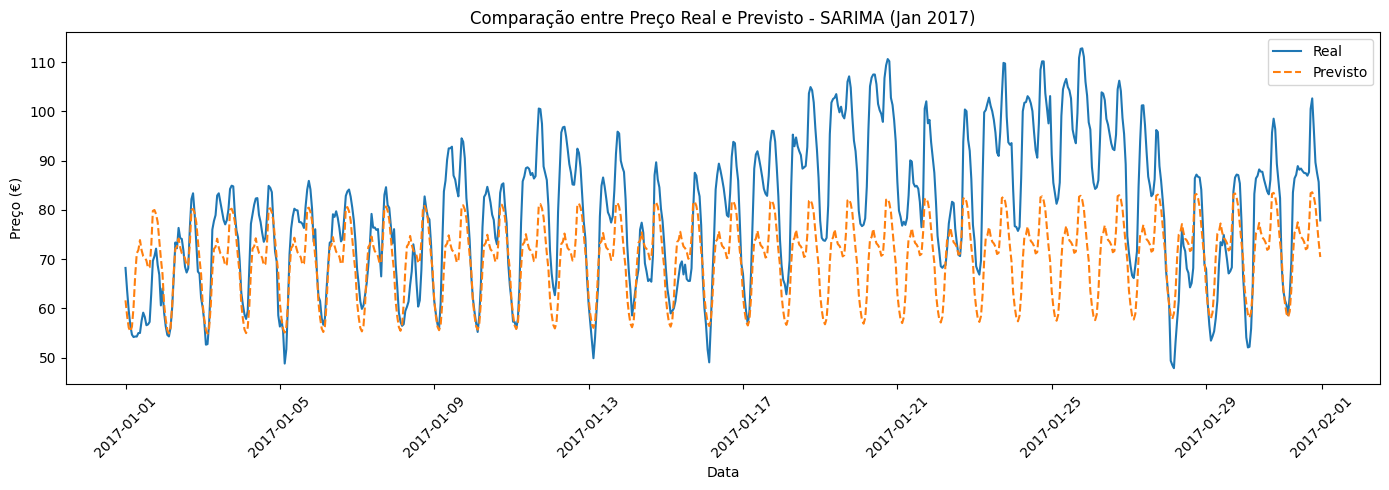

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

df = pd.read_csv("dataset.csv", parse_dates=["time"], index_col="time")
df.index = df.index.tz_localize(None)

train_start = '2015-01-01'
train_end = '2016-12-31'
test_start = '2017-01-01'
test_end = '2017-01-31'

df_train = df.loc[train_start:train_end]
df_test = df.loc[test_start:test_end]

model = SARIMAX(
    df_train['price actual'],
    order=(1, 1, 2),
    seasonal_order=(2, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=len(df_test))

y_true = df_test['price actual'].values
y_pred = forecast.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
rmae = mae / np.mean(np.abs(y_true))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE (%): {mape:.4f}")
print(f"rMAE: {rmae:.4f}")

comparison_df = pd.DataFrame({
    'Date': df_test.index,
    'Real': y_true,
    'Forecasted': y_pred
}).set_index('Data')

plt.figure(figsize=(14, 5))
plt.plot(comparison_df['Real'], label='Real')
plt.plot(comparison_df['Forecasted'], label='Forecasted', linestyle='--')
plt.title("Comparation with real - SARIMA (Jan 2017)")
plt.xlabel("Data")
plt.ylabel("Preço (€)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# LSTM forecasting 1 day during 1 month

c:\Users\Gonçalo Pereira\Documents\GitHub\DIMEI\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



📊 LSTM - January Forecast 2017:
MAE: 7.41
RMSE: 9.62
MAPE (%): 9.27
rMAE: 0.0926


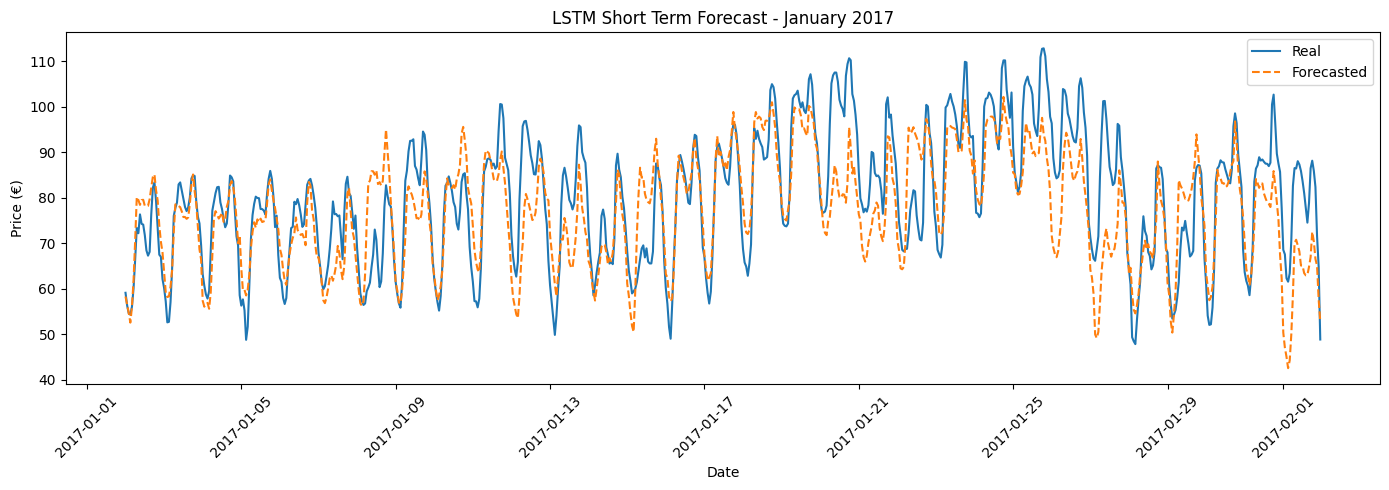

📈 Gráfico guardado como 'lstm_forecast_jan2017.png'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

def lstm_forecast_jan2017(df):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    train_start = '2015-01-01'
    train_end = '2016-12-31'
    test_start = '2017-01-01'
    test_end = '2017-01-31'

    forecast_horizon = 24
    timesteps = 24
    units = 100
    dropout = 0.3
    num_layers = 2
    learning_rate = 0.0005
    loss_function = Huber(delta=1.0)
    epochs = 20
    batch_size = 32

    df_train = df.loc[train_start:train_end]
    df_test = df.loc[test_start:test_end]

    feature_cols = [col for col in df.columns if col not in ['price actual', 'price day ahead']]
    X_train = df_train[feature_cols].values
    y_train = df_train['price actual'].values
    y_train_shifted = y_train[timesteps:]
    X_train = X_train[:-timesteps]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

    X_seq, y_seq = [], []
    for i in range(timesteps, len(X_train_scaled)):
        X_seq.append(X_train_scaled[i - timesteps:i])
        y_seq.append(y_train_scaled[i])
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)

    model = Sequential()
    model.add(LSTM(units=units, activation='tanh', return_sequences=True, input_shape=(timesteps, X_seq.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function)

    model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, callbacks=[
        EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    ], verbose=0)

    all_preds = []
    all_truths = []
    all_dates = []

    for day in pd.date_range(test_start, test_end, freq='D'):
        window_start = day
        window_end = day + pd.Timedelta(hours=timesteps + forecast_horizon - 1)
        df_window = df.loc[window_start:window_end]
        if len(df_window) < timesteps + forecast_horizon:
            continue

        preds = []
        for i in range(forecast_horizon):
            input_seq = df_window[feature_cols].iloc[i:i + timesteps].values
            if input_seq.shape[0] < timesteps:
                break
            input_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        real_vals = df_window['price actual'].iloc[timesteps:timesteps + len(preds)].values
        all_preds.extend(preds[:len(real_vals)])
        all_truths.extend(real_vals)
        all_dates.extend(df_window.index[timesteps:timesteps + len(real_vals)])

    mae = mean_absolute_error(all_truths, all_preds)
    rmse = np.sqrt(mean_squared_error(all_truths, all_preds))
    mape = mean_absolute_percentage_error(all_truths, all_preds) * 100
    rmae = mae / np.mean(np.abs(all_truths))

    print("\n📊 LSTM - January Forecast 2017:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE (%): {mape:.2f}")
    print(f"rMAE: {rmae:.4f}")


    plt.figure(figsize=(14, 5))
    plt.plot(all_dates, all_truths, label='Real')
    plt.plot(all_dates, all_preds, label='Forecasted', linestyle='--')
    plt.title("LSTM Short Term Forecast - January 2017")
    plt.xlabel("Date")
    plt.ylabel("Price (€)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("lstm_forecast_jan2017.png", dpi=300)
    plt.show()
    print("📈 Stored as 'lstm_forecast_jan2017.png'")

lstm_forecast_jan2017(df_prepared)


# XGBoost forecasting 1 day during 1 month

In [ ]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def shortterm_sliding_expanding_xgb_tunning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=24,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    all_preds = []
    all_truths = []
    all_dates = []

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        all_preds.extend(y_pred)
        all_truths.extend(y_test)
        all_dates.extend(df_test.index)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(days=1)
        step += 1


    if all_preds:
        plt.figure(figsize=(14, 5))
        plt.plot(all_dates, all_truths, label='Real', linewidth=1.5)
        plt.plot(all_dates, all_preds, label='Forecasted', linestyle='--', linewidth=1.5)
        plt.title("XGBoost – Short Term Forecast January 2017")
        plt.xlabel("Date")
        plt.ylabel("Price (€)")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


        mae_total = mean_absolute_error(all_truths, all_preds)
        rmse_total = np.sqrt(mean_squared_error(all_truths, all_preds))
        mape_total = mean_absolute_percentage_error(all_truths, all_preds) * 100
        rmae_total = mae_total / np.mean(np.abs(all_truths))

        print("\n📊 Total metrics for January 2017:")
        print(f"MAE: {mae_total:.4f}")
        print(f"RMSE: {rmse_total:.4f}")
        print(f"MAPE (%): {mape_total:.4f}")
        print(f"rMAE: {rmae_total:.4f}")

    return pd.DataFrame(results)

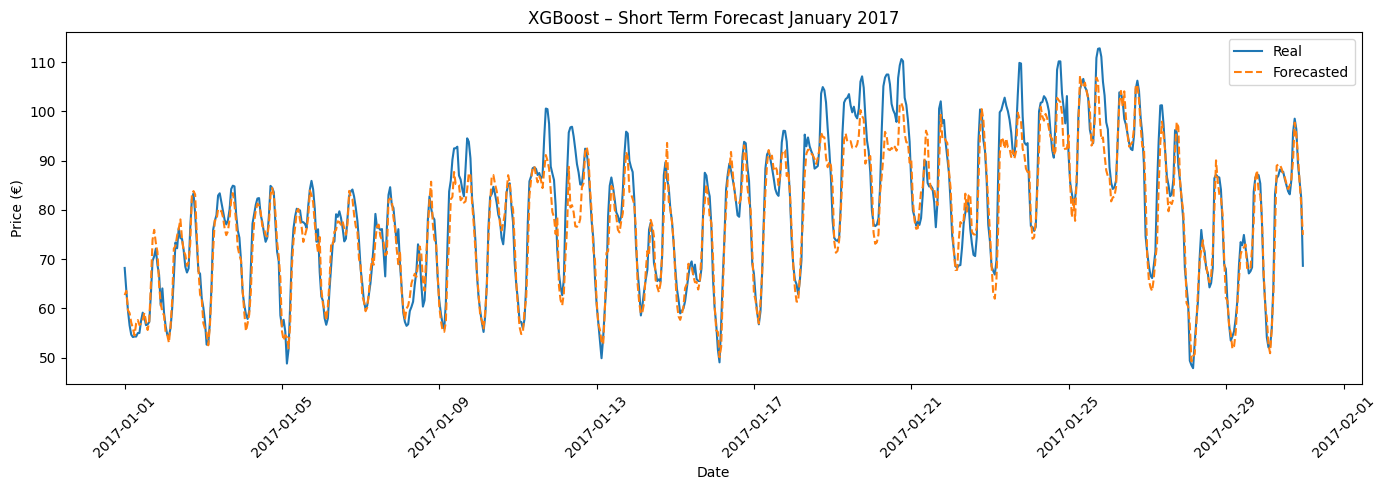


📊 Métricas totais para Janeiro 2017:
MAE: 3.1099
RMSE: 4.3271
MAPE (%): 3.7586
rMAE: 0.0392


In [32]:
xgb_results_jan2017 = shortterm_sliding_expanding_xgb_tunning(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-01-31',
    forecast_horizon=24,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8
)


In [ ]:
import numpy as np
from scipy.stats import t

def diebold_mariano_test(e1, e2, h=1, loss='abs'):
    """
    e1, e2: arrays de erros dos dois modelos (ex: y_true - y_pred)
    h: horizonte da previsão (1 para one-step-ahead)
    loss: 'abs' para MAE, 'squared' para MSE
    """
    e1 = np.array(e1)
    e2 = np.array(e2)

    if loss == 'squared':
        d = e1**2 - e2**2
    elif loss == 'abs':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("Loss must be 'abs' or 'squared'")

    mean_d = np.mean(d)
    n = len(d)
    var_d = np.var(d, ddof=1)

    dm_stat = mean_d / np.sqrt((var_d / n) + 2 * np.sum([
        (1 - k / h) * np.cov(d[:-k], d[k:])[0, 1] for k in range(1, h)
    ]) / n if h > 1 else (var_d / n))

    p_value = 2 * (1 - t.cdf(np.abs(dm_stat), df=n-1))
    return dm_stat, p_value


In [ ]:
y_true = rf_result_forecast24['y_test']
xgb_pred = xgb_result_forecast24['y_pred']
rf_pred = rf_result_forecast24['y_pred']

e_xgb = y_true - xgb_pred
e_rf = y_true - rf_pred

dm_stat, p_val = diebold_mariano_test(e_xgb, e_rf, h=1, loss='abs')
print(f'DM Statistic: {dm_stat:.4f}, p-value: {p_val:.4f}')

